# Time Series Model for Monthly Armed Robberies in Boston Using Python
### David Lowe
### January 23, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

Code Credit: Adapted from a blog post made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/

PREFACE: This is a replication of Python code from Dr. Brownlee's blog post on time series. I have combined all the code snippets into one script so that I could turn the whole process into a template. The comments and analysis were also part of the blog post and annotated here to explain each coding block.

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Monthly Armed Robberies in Boston dataset is a time series situation where we are trying to forecast future outcomes based on the past data points.

INTRODUCTION: The problem is to predict the number of monthly armed robberies in Boston, USA. The dataset provides the number of monthly armed robberies in Boston from January 1966 to October 1975, Monthly Boston armed robberies Jan.1966-Oct.1975 Deutsch and Alt (1977) and credited to McCleary & Hay (1980).

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 51.8. The manually configured model was simplified to ARIMA(0,1,2) and produced an RMSE of 49.8, which was slightly better than the persistent model. After applying the power transformation (Box-Cox) to the dataset, the final RMSE of the model on the transformed data was 49.4. This is only a slightly smaller error than the ARIMA model on untransformed data, and it may or may not be statistically different.

CONCLUSION: The final RMSE for the validation period was predicted at 53 robberies, and it was not too different from the expected error of 49. Although the forecast appears to have the characteristic of a persistence forecast, this does suggest that, while this time series does have an obvious trend, it is still a reasonably difficult problem.

Dataset Used: Monthly Armed Robberies in Boston

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://datamarket.com/data/set/22ob/monthly-boston-armed-robberies-jan1966-oct1975-deutsch-and-alt-1977#!ds=22ob&display=line

One potential source of performance benchmark: https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize and Deploy Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
import numpy as np
import pandas as pd
import smtplib
import warnings
from datetime import datetime
from email.message import EmailMessage
from math import exp
from math import log
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error

# Create a random seed number variable for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = "luozhi2488@gmail.com"
    receiver = "dave@contactdavidlowe.com"
    with open('../email_credential.txt') as f:
        password = f.readline()
        f.close()
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Program Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

The dataset is not current. This means that we cannot easily collect updated data to validate the model. Therefore we will pretend that it is October 1974 and withhold the last one year of data from analysis and model selection. This final year of data will be used to validate the final model.

The code below will load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv). The specific contents of these files are:

* dataset.csv: Observations from January 1966 to October 1974 (106 observations)
* validation.csv: Observations from November 1974 to October 1975 (12 observations)

In [4]:
startTimeScript = datetime.now()

In [5]:
# split into a training and validation dataset
series = read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 106, Validation 12


### 1.d) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

Candidate models will be evaluated using walk-forward validation. This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

* The first 50% of the dataset will be held back to train the model.
* The remaining 50% of the dataset will be iterated and test the model.
* For each step in the test dataset:
    * A model will be trained.
    * A one-step prediction made and the prediction stored for later evaluation.
    * The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Given the small size of the data, we will allow a model to be re-trained given all available data prior to each prediction.

In [6]:
# evaluate a persistence model
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=98.000, Expected=125
>Predicted=125.000, Expected=155
>Predicted=155.000, Expected=190
>Predicted=190.000, Expected=236
>Predicted=236.000, Expected=189
>Predicted=189.000, Expected=174
>Predicted=174.000, Expected=178
>Predicted=178.000, Expected=136
>Predicted=136.000, Expected=161
>Predicted=161.000, Expected=171
>Predicted=171.000, Expected=149
>Predicted=149.000, Expected=184
>Predicted=184.000, Expected=155
>Predicted=155.000, Expected=276
>Predicted=276.000, Expected=224
>Predicted=224.000, Expected=213
>Predicted=213.000, Expected=279
>Predicted=279.000, Expected=268
>Predicted=268.000, Expected=287
>Predicted=287.000, Expected=238
>Predicted=238.000, Expected=213
>Predicted=213.000, Expected=257
>Predicted=257.000, Expected=293
>Predicted=293.000, Expected=212
>Predicted=212.000, Expected=246
>Predicted=246.000, Expected=353
>Predicted=353.000, Expected=339
>Predicted=339.000, Expected=308
>Predicted=308.000, Expected=247
>Predicted=247.000, Expected=257
>Predicted=

In [7]:
email_notify("Program Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [8]:
email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with. Some observations from these statistics include:

* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 173, which we might consider our level in this series.
* The standard deviation (average spread from the mean) is relatively large at 112 robberies.
* The percentiles along with the standard deviation do suggest a large spread to the data.

The large spread in this series will likely make highly accurate predictions difficult if it is caused by random fluctuation (e.g. not systematic).

In [9]:
# summary statistics of time series
print(series.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: 1, dtype: float64


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot include:

* There is an increasing trend of robberies over time.
* There do not appear to be any obvious outliers.
* There are relatively large fluctuations from year to year, up and down.
* The fluctuations at later years appear larger than fluctuations at earlier years.
* The trend means the dataset is almost certainly non-stationary and the apparent change in fluctuation may also contribute.

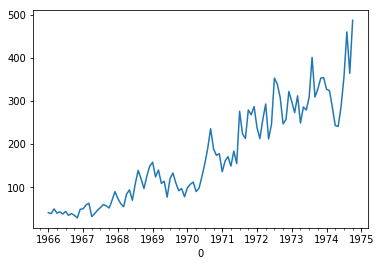

In [10]:
# line plots of time series
series.plot()
pyplot.show()

### 2.c) Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots include:

* The distribution is not Gaussian.
* The distribution is left shifted and may be exponential or a double Gaussian.

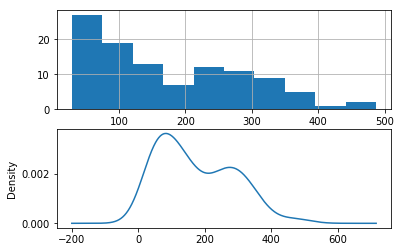

In [11]:
# density plots of time series
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group the monthly data by year and get an idea of the spread of observations for each year and how this may be changing. We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.

Some observations from reviewing the plot include:

* The median values for each year (red line) show a trend that may not be linear.
* The spread, or middle 50% of the data (blue boxes), differ, but perhaps not consistently over time.
* The earlier years, perhaps first 2, are quite different from the rest of the dataset.

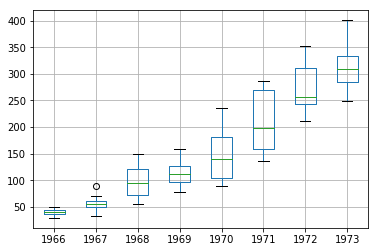

In [12]:
# boxplots of time series
groups = series['1966':'1973'].groupby(Grouper(freq='A'))
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

In [13]:
email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Clean and Pre-Process Data

This section currently is not applicable to this iteration of the project.

In [14]:
email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [15]:
email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregression Integrated Moving Average, or ARIMA, models for the problem. We will approach this in four steps:

* Developing a manually configured ARIMA model.
* Using a grid search of ARIMA to find an optimized model.
* Analysis of forecast residual errors to evaluate any bias in the model.
* Explore improvements to the model using power transforms.

In [16]:
email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Manually Configured ARIMA

In [17]:
email_notify("Performing Manual ARIMA has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

#### 4.a.i) Statistical Test for the Stationarity of the Time Series Data

Nonseasonal ARIMA(p,d,q) requires three parameters and is traditionally configured manually. Analysis of the time series data assumes that we are working with a stationary time series.

The time series is almost certainly non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

The results show that the test statistic value -3.980946 is smaller than the critical value at 5% of -2.893. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure. This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

In [18]:
# statistical test for the stationarity of the time series
# create a differenced time series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

X = series.values
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')

ADF Statistic: -3.980946
p-value: 0.001514
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


#### 4.a.ii) ACF and PACF Plots of the Time Series Data

The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

Below are some observations from the plots.

* The ACF shows a significant lag for 1 month.
* The PACF shows a significant lag for perhaps 2 months, with significant lags spotty out to perhaps 12 months.
* Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.

A good starting point for the p and q values is 1 or 2. This quick analysis suggests an ARIMA(1,1,2) on the raw data may be a good starting point.

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


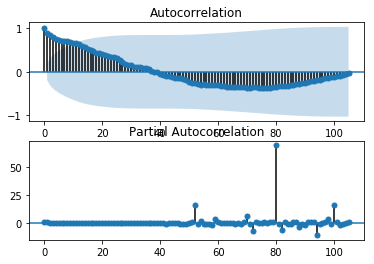

In [19]:
# ACF and PACF plots of time series
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

#### 4.a.iii) Evaluate Manually Configured ARIMA Model

Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Some experimentation shows that the model does not appear to be stable, with non-zero AR and MA orders defined at the same time.

The model can be simplified to ARIMA(0,1,2). Running this configuration results in an RMSE of 49.821, which is lower than the persistence model. This is a good start, but we may be able to get improved results with a better configured ARIMA model.

In [20]:
# evaluate manually configured ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

C:\Users\user_hhds7y1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


>Predicted=102.710, Expected=125
>Predicted=118.868, Expected=155
>Predicted=141.099, Expected=190
>Predicted=176.593, Expected=236
>Predicted=233.418, Expected=189
>Predicted=186.905, Expected=174
>Predicted=184.846, Expected=178
>Predicted=183.763, Expected=136
>Predicted=146.180, Expected=161
>Predicted=171.279, Expected=171
>Predicted=170.196, Expected=149
>Predicted=154.425, Expected=184
>Predicted=185.707, Expected=155
>Predicted=157.284, Expected=276
>Predicted=245.280, Expected=224
>Predicted=222.242, Expected=213
>Predicted=219.698, Expected=279
>Predicted=261.506, Expected=268
>Predicted=264.287, Expected=287
>Predicted=282.759, Expected=238
>Predicted=255.843, Expected=213
>Predicted=235.189, Expected=257
>Predicted=257.622, Expected=293
>Predicted=280.345, Expected=212
>Predicted=235.564, Expected=246
>Predicted=255.342, Expected=353
>Predicted=318.613, Expected=339
>Predicted=310.335, Expected=308
>Predicted=306.789, Expected=247
>Predicted=270.213, Expected=257
>Predicted

In [21]:
email_notify("Performing Manual ARIMA completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.b) Grid Search of ARIMA Hyperparameters

Many ARIMA configurations are unstable on this dataset, but there may be other hyperparameters that result in a well-performing model. In this section, we will search values of p, d, and q for combinations that do not result in error, and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

* p: 0 to 12.
* d: 0 to 3.
* q: 0 to 12.

The results show that the best configuration discovered was ARIMA(0, 1, 2); coincidently, that was demonstrated in the previous section.

In [22]:
email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# grid search ARIMA parameters for time series
startTimeModule = datetime.now()
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0,13)
d_values = range(0,4)
q_values = range(0,13)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)
print ('Model training time:',(datetime.now() - startTimeModule))

ARIMA(0, 0, 0) RMSE=154.962
ARIMA(0, 0, 1) RMSE=99.360
ARIMA(0, 1, 0) RMSE=51.827
ARIMA(0, 1, 1) RMSE=50.417
ARIMA(0, 1, 2) RMSE=49.821
ARIMA(0, 2, 0) RMSE=80.804
ARIMA(0, 2, 1) RMSE=52.456
ARIMA(1, 0, 0) RMSE=53.243
ARIMA(1, 1, 0) RMSE=50.582
ARIMA(1, 2, 0) RMSE=68.672
ARIMA(2, 0, 0) RMSE=52.032
ARIMA(2, 1, 0) RMSE=50.761
ARIMA(2, 1, 1) RMSE=50.407
ARIMA(2, 2, 0) RMSE=61.384
ARIMA(2, 2, 1) RMSE=51.388
ARIMA(3, 1, 0) RMSE=51.901
ARIMA(3, 1, 1) RMSE=50.295
ARIMA(3, 2, 0) RMSE=60.411
ARIMA(3, 2, 1) RMSE=52.830
ARIMA(4, 1, 0) RMSE=52.420
ARIMA(4, 1, 1) RMSE=52.295
ARIMA(4, 2, 0) RMSE=56.286
ARIMA(4, 2, 1) RMSE=53.207
ARIMA(5, 1, 0) RMSE=52.653
ARIMA(5, 1, 1) RMSE=52.883
ARIMA(5, 2, 0) RMSE=57.370
ARIMA(5, 2, 1) RMSE=53.203
ARIMA(6, 1, 0) RMSE=52.437
ARIMA(6, 2, 0) RMSE=58.307
ARIMA(7, 0, 0) RMSE=54.232
ARIMA(7, 1, 0) RMSE=51.104
ARIMA(7, 1, 1) RMSE=52.340
ARIMA(8, 1, 0) RMSE=51.759
ARIMA(9, 1, 0) RMSE=52.491
Best ARIMA(0, 1, 2) RMSE=49.821
Model training time: 1:07:10.686682


In [24]:
email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Review Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by plotting the residuals with a histogram and density plots. The graphs suggest a Gaussian-like distribution with a longer right tail.

This is perhaps a sign that the predictions are biased, and in this case that perhaps a power-based transform of the raw data before modeling might be useful.

In [25]:
email_notify("Residual Errors Review has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

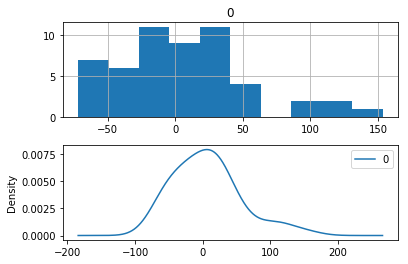

In [26]:
# plot residual errors for ARIMA model
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

It is also a good idea to check the time series of the residual errors for any type of autocorrelation. If present, it would suggest that the model has more opportunity to model the temporal structure in the data.

The results suggest that what little autocorrelation is present in the time series has been captured by the model.

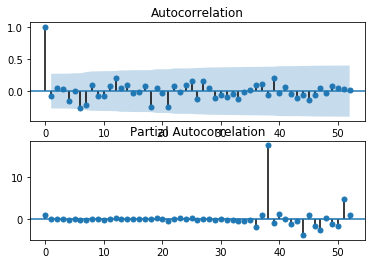

In [27]:
# ACF and PACF plots of forecast residual errors
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

In [28]:
email_notify("Residual Errors Review completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.d) Explore Model Improvements Using Power Transforms

The Box-Cox transform is a method that is able to evaluate a suite of power transforms, including, but not limited to, log, square root, and reciprocal transforms of the data.

Running the code block creates three graphs: a line chart of the transformed time series, a histogram showing the distribution of transformed values, and a Q-Q plot showing how the distribution of values compared to an idealized Gaussian distribution. Some observations from these plots are follows:

* The large fluctuations have been removed from the line plot of the time series.
* The histogram shows a flatter or more uniform (well behaved) distribution of values.
* The Q-Q plot is reasonable, but still not a perfect fit for a Gaussian distribution.

Undoubtedly, the Box-Cox transform has done something to the time series and may be useful.

In [29]:
email_notify("Power Transformation Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Lambda: 0.260060


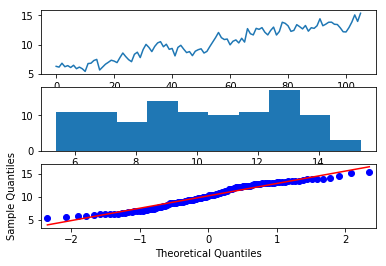

In [30]:
# plots of box-cox transformed dataset
X = series.values
transformed, lam = boxcox(X)
print('Lambda: %f' % lam)
pyplot.figure(1)
# line plot
pyplot.subplot(311)
pyplot.plot(transformed)
# histogram
pyplot.subplot(312)
pyplot.hist(transformed)
# q-q plot
pyplot.subplot(313)
qqplot(transformed, line='r', ax=pyplot.gca())
pyplot.show()

Before proceeding to test the ARIMA model with the transformed data, we must have a way to reverse the transform in order to convert predictions made with a model trained on the transformed data back into the original scale. The boxcox() function used in the example finds an ideal lambda value by optimizing a cost function.

We can re-evaluate the ARIMA(0,1,2) model with the Box-Cox transform. This involves first transforming the history prior to fitting the ARIMA model, then inverting the transform on the prediction before storing it for later comparison with the expected values.

The boxcox() function can fail. In practice, it appears to be signaled by a returned lambda value of less than -5. By convention, lambda values are evaluated between -5 and 5. A check is added for a lambda value less than -5, and if this the case, a lambda value of 1 is assumed and the raw history is used to fit the model. A lambda value of 1 is the same as “no-transform” and therefore the inverse transform has no effect.

The final RMSE of the model on the transformed data was 49.443. This is a smaller error than the ARIMA model on untransformed data, but only slightly, and it may or may not be statistically different.

In [31]:
# evaluate ARIMA models with box-cox transformed time series
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=104.062, Expected=125
>Predicted=119.208, Expected=155
>Predicted=138.902, Expected=190
>Predicted=166.143, Expected=236
>Predicted=234.418, Expected=189
>Predicted=183.613, Expected=174
>Predicted=184.409, Expected=178
>Predicted=186.641, Expected=136
>Predicted=154.300, Expected=161
>Predicted=175.672, Expected=171
>Predicted=174.172, Expected=149
>Predicted=159.915, Expected=184
>Predicted=187.303, Expected=155
>Predicted=161.656, Expected=276
>Predicted=244.354, Expected=224
>Predicted=212.416, Expected=213
>Predicted=221.180, Expected=279
>Predicted=262.629, Expected=268
>Predicted=260.126, Expected=287
>Predicted=283.320, Expected=238
>Predicted=255.089, Expected=213
>Predicted=241.692, Expected=257
>Predicted=267.306, Expected=293
>Predicted=286.371, Expected=212
>Predicted=237.881, Expected=246
>Predicted=265.193, Expected=353
>Predicted=323.314, Expected=339
>Predicted=318.589, Expected=308
>Predicted=315.815, Expected=247
>Predicted=279.552, Expected=257
>Predicted

In [32]:
email_notify("Power Transformation Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [33]:
email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize and Deploy Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

This section includes the following steps:

* Finalize Model: Train and save the final model.
* Make Prediction: Load the finalized model and make a prediction.
* Validate Model: Load and validate the final model.

In [34]:
email_notify("Model Finalization and Deployment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Finalize Model

Finalizing the model involves fitting an ARIMA model on the entire dataset, in this case, on a transformed version of the entire dataset.

Once fit, the model can be saved to file for later use. Because a Box-Cox transform is also performed on the data, we need to know the chosen lambda so that any predictions from the model can be converted back to the original, untransformed scale.

Running the code block creates two local files:

* model.pkl This is the ARIMAResult object from the call to ARIMA.fit(). This includes the coefficients and all other internal data returned when fitting the model.
* model_lambda.npy This is the lambda value stored as a one-row, one-column NumPy array.

In [35]:
# finalize model and save to file with workaround
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# transform data
transformed, lam = boxcox(X)
# fit model
model = ARIMA(transformed, order=(0,1,2))
model_fit = model.fit(disp=0)
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

### 5.b) Make Prediction

A natural case may be to load the model and make a single forecast. This is relatively straightforward and involves restoring the saved model and the lambda and calling the forecast() method.

We can now load the model and make a single prediction. Running the code block points to the prediction of about 452.

In [36]:
# load the finalized model and make a prediction
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 452.043


### 5.c) Validate Model

We can load the model and use it in a pretend operational manner. In the test harness section, we saved the final 12 months of the original dataset in a separate file to validate the final model. We can load this validation.csv file now and use it see how well our model really is on “unseen” data.

There are two ways we might proceed:

* Load the model and use it to forecast the next 12 months. The forecast beyond the first one or two months will quickly start to degrade in skill.
* Load the model and use it in a rolling-forecast manner, updating the transform and model for each time step. This is the preferred method as it is how one would use this model in practice, as it would achieve the best performance.

As with model evaluation in previous sections, we will make predictions in a rolling-forecast manner. This means that we will step over lead times in the validation dataset and take the observations as an update to the history.

The final RMSE for the validation period is predicted at 53 robberies. This is not too different to the expected error of 49. The forecast does have the characteristic of a persistence forecast. This does suggest that although this time series does have an obvious trend, it is still a reasonably difficult problem.

>Predicted=452.043, Expected=452
>Predicted=423.088, Expected=391
>Predicted=408.378, Expected=500
>Predicted=482.454, Expected=451
>Predicted=445.944, Expected=375
>Predicted=413.881, Expected=372
>Predicted=413.209, Expected=302
>Predicted=355.159, Expected=316
>Predicted=363.515, Expected=398
>Predicted=406.365, Expected=394
>Predicted=394.186, Expected=431
>Predicted=428.174, Expected=431
RMSE: 53.078


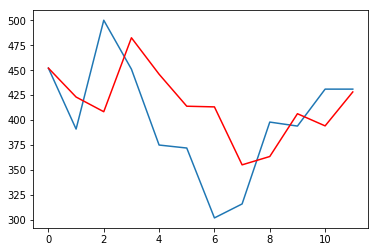

In [37]:
# evaluate the finalized model on the validation dataset
# invert box-cox transform
def boxcox_inverse(value, lam):
	if lam == 0:
		return exp(value)
	return exp(log(lam * value + 1) / lam)

# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# transform
	transformed, lam = boxcox(history)
	if lam < -5:
		transformed, lam = history, 1
	# predict
	model = ARIMA(transformed, order=(0,1,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	# invert transformed prediction
	yhat = boxcox_inverse(yhat, lam)
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

In [38]:
email_notify("Model Finalization and Deployment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:08:00.186069
